In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
import pickle
import glob

In [2]:
def noise_probability(p_P, N_P, p_R, N_R, p_F, N_F, p_X, N_X):
    """
    Compute the total noise probability based on noise from preparation (p_P), 
    readout (p_R), and any other operation (p_F) affecting N_P, N_R, and N_F particles.
    """
    p_noise = 1 - (1 - p_P)**N_P * (1 - p_R)**N_R * (1 - p_F)**N_F*(1-p_X)**N_X
    return p_noise

def decoherence_model(N, p_P, N_P, p_R, N_R, p_F, N_F, p_X, N_X, rho_ideal):
    """
    Simulate the decoherence of a GHZ state by constructing the mixed density matrix.
    
    Parameters:
    N (int): Number of particles (qubits) in the GHZ state.
    p_P, p_R, p_F (float): Noise rates for preparation, readout, and other operations.
    N_P, N_R, N_F (int): Number of particles affected by each operation.
    rho_ideal (np.ndarray): Ideal density matrix of the GHZ state.

    Returns:
    rho_exp (np.ndarray): Experimental density matrix after noise effects.
    """
    # Compute noise probability
    p_noise = noise_probability(p_P, N_P, p_R, N_R, p_F, N_F, p_X, N_X)
    
    # Identity matrix representing the maximally mixed state (I / 2^N)
    dim = 2**N  # Dimension of the Hilbert space
    identity_matrix = np.eye(dim)
    maximally_mixed_state = identity_matrix / dim
    
    # Calculate the noisy (experimental) density matrix
    rho_exp = (1 - p_noise) * rho_ideal + p_noise * maximally_mixed_state
    
    return rho_exp

def construct_ghz_state(N):
    """
    Constructs the N-particle GHZ state.
    
    Parameters:
    N (int): Number of particles (qubits) in the GHZ state.
    
    Returns:
    np.ndarray: Density matrix of the ideal GHZ state.
    """
    # Basis vectors for |0^N> and |1^N>
    zero_state = np.zeros(2**N)
    zero_state[0] = 1  # |0^N>
    
    one_state = np.zeros(2**N)
    one_state[-1] = 1  # |1^N>
    
    # GHZ state: (|0^N> + |1^N>) / sqrt(2)
    ghz_state = (zero_state + one_state) / np.sqrt(2)
    
    # Density matrix of the GHZ state: |GHZ><GHZ|
    rho_ideal = np.outer(ghz_state, ghz_state.conj())
    
    return rho_ideal

def fidelity(rho_ideal, rho_noisy):
    """
    Calculate the fidelity between the ideal and noisy density matrices.
    
    Parameters:
    rho_ideal (np.ndarray): Ideal density matrix (GHZ state).
    rho_noisy (np.ndarray): Noisy density matrix.
    
    Returns:
    float: Fidelity between rho_ideal and rho_noisy.
    """
    # sqrtm computes the matrix square root
    sqrt_rho_ideal = sqrtm(rho_ideal)
    product = sqrt_rho_ideal @ rho_noisy @ sqrt_rho_ideal
    fidelity_value = np.trace(sqrtm(product))**2
    return np.real(fidelity_value)  # Ensure the fidelity is a real number

def N_state_fidelity(N, p_P, p_R, p_F, p_X):
    """
    Calculate the fidelity of the noisy state with the ideal GHZ state.
    
    Parameters:
    N (int): Number of particles (qubits) in the GHZ state.
    p_P, p_R, p_F (float): Noise rates for preparation, readout, and other operations.
    N_P, N_R, N_F (int): Number of particles affected by each operation.
    
    Returns:
    float: Fidelity between the ideal and noisy states.
    """

    # Number of particles affected by each noise source
    N_fst=1
    N_sti=1
    N_sti_late=2*(N-1)
    N_vst=2*N

    # Construct the ideal GHZ state
    rho_ideal = construct_ghz_state(N)
    
    # Simulate the decoherence of the GHZ state
    rho_noisy = decoherence_model(N, p_P, N_fst, p_R, N_sti, p_F, N_sti_late, p_X, N_vst, rho_ideal)
    
    # Calculate the fidelity between the ideal and noisy states
    f = fidelity(rho_ideal, rho_noisy)

    return f


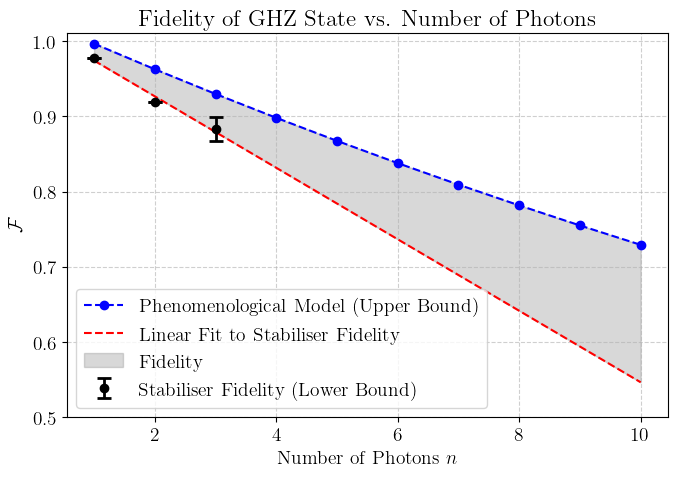

In [7]:
from numpy.polynomial import Polynomial

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 14
})

# Define noise parameters
p_fst = 0.011  # fSTIRAP Noise
p_sti = 0.015  # STIRAP 2 Noise
p_sti_late = 0.0075  # STIRAP 3/4 Noise
p_vst = 0.001  # VSTIRAP Noise

# Manual data points
manual_data_n = np.array([1, 2, 3])
manual_data_fid = np.array([0.978, 0.9185235554055327, 0.883])
manual_data_error_bars=np.array([4e-7, 0.00022480057684297436, 0.015810514883468373])
#this is the FD data
#manual_data_fid = np.array([0.98, 0.934, 0.879])


# Define the fidelity model (placeholder for actual function)
def N_state_fidelity(N, p_fst, p_sti, p_sti_late, p_vst):
    # Example exponential decay model
    return (1 - p_fst)**N * (1 - p_sti)**(N - 1) * (1 - p_sti_late)**(N - 2) * (1 - p_vst)**(N - 1)

# Compute phenomenological fidelity for N = 1 to 10
N_vals = np.arange(1, 11)
fidelities = np.array([N_state_fidelity(N, p_fst, p_sti, p_sti_late, p_vst) for N in N_vals])

# Fit cubic polynomial to manual data
poly = Polynomial.fit(manual_data_n, manual_data_fid, deg=1)
N_interp = np.linspace(1, 10, 200)
fid_interp = poly(N_interp)

# Interpolated manual data for shading
fid_interp_match = poly(N_vals)

# Plot
fig, ax = plt.subplots(figsize=(7, 5))

# Plot phenomenological model
ax.plot(N_vals, fidelities, 'o--', color='blue', label='Phenomenological Model (Upper Bound)')

# Plot fitted polynomial
ax.plot(N_interp, fid_interp, '--', color='red', label='Linear Fit to Stabiliser Fidelity')

# Plot manual data points
#ax.plot(manual_data_n,
#        manual_data_fid,
#        'o',
#        color='black',
#        label='Stabiliser Fidelity (Lower Bound)')
#add error bars
ax.errorbar(manual_data_n,
            manual_data_fid,
            yerr=manual_data_error_bars,
            fmt='o',
            color='black',
            label='Stabiliser Fidelity (Lower Bound)',
            capsize=5,
            elinewidth=2,
            capthick=2)

# Shade the area between models
ax.fill_between(N_vals, fidelities, fid_interp_match, color='gray', alpha=0.3, label='Fidelity')

# Labels and title
ax.set_xlabel(r'Number of Photons $n$')
ax.set_ylabel(r'$\mathcal{F}$')
ax.set_title(r'Fidelity of GHZ State vs. Number of Photons')
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_ylim(0.5, 1.01)

# Legend
ax.legend( frameon=True)

# Show plot
plt.tight_layout()
plt.show()